In [2]:
import sympy as sym
from sympy import Matrix
import math

from mitroiki_functs import K_truss
from mitroiki_functs import TransformMatrixTruss
from mitroiki_functs import round_expr

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

from IPython.display import Image

# Εφαρμογή 9 - Δικτύωμα

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τα διαγράμματα των εντατικών μεγεθών για τον φορέα του σχήματος.

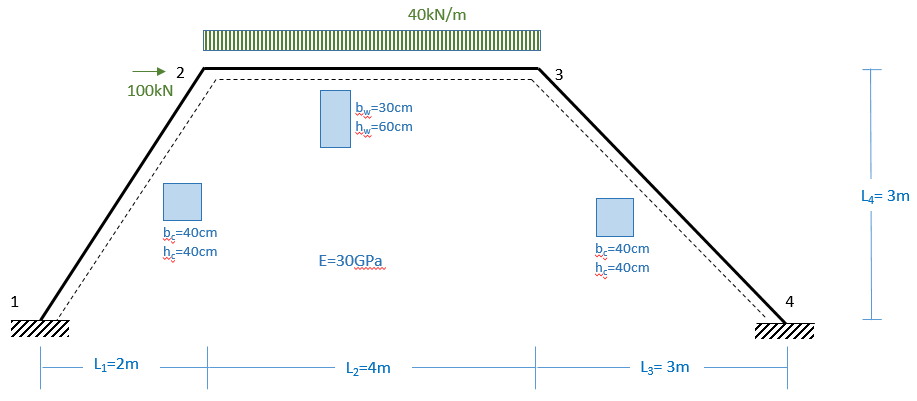

In [316]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example8/ekfonisi.png", width=800)

In [3]:
E = 200_000_000.
A = 1e-4 / math.sqrt(2)

L = 10.

F = 100.

In [6]:
K1 = K2 = K_truss(A=A,
                  E=E,
                  L=L*math.sqrt(2))
K1

Matrix([
[ 1000.0, -1000.0],
[-1000.0,  1000.0]])

In [9]:
Λ1 = TransformMatrixTruss(math.pi/4)
round_expr(Λ1, 4)

Matrix([
[0.7071,      0],
[0.7071,      0],
[     0, 0.7071],
[     0, 0.7071]])

In [17]:
K1_trans = Λ1 * K1 * Λ1.transpose()
K1_trans

Matrix([
[ 500.0,  500.0, -500.0, -500.0],
[ 500.0,  500.0, -500.0, -500.0],
[-500.0, -500.0,  500.0,  500.0],
[-500.0, -500.0,  500.0,  500.0]])

In [12]:
Λ2 = TransformMatrixTruss(-math.pi/4)
round_expr(Λ2, 4)

Matrix([
[ 0.7071,       0],
[-0.7071,       0],
[      0,  0.7071],
[      0, -0.7071]])

In [18]:
K2_trans = Λ2 * K2 * Λ2.transpose()
K2_trans

Matrix([
[ 500.0, -500.0, -500.0,  500.0],
[-500.0,  500.0,  500.0, -500.0],
[-500.0,  500.0,  500.0, -500.0],
[ 500.0, -500.0, -500.0,  500.0]])

In [ ]:
K2global = Λ1 * K1 * Λ1.transpose()
K2global

In [19]:
K1_temp = sym.zeros(6,6)
K1_temp[:4, :4] += K1_trans
round_expr(K1_temp, 1)

Matrix([
[ 500.0,  500.0, -500.0, -500.0, 0, 0],
[ 500.0,  500.0, -500.0, -500.0, 0, 0],
[-500.0, -500.0,  500.0,  500.0, 0, 0],
[-500.0, -500.0,  500.0,  500.0, 0, 0],
[     0,      0,      0,      0, 0, 0],
[     0,      0,      0,      0, 0, 0]])

In [21]:
K2_temp = sym.zeros(6,6)
K2_temp[2:, 2:] += K2_trans
round_expr(K2_temp, 1)

Matrix([
[0, 0,      0,      0,      0,      0],
[0, 0,      0,      0,      0,      0],
[0, 0,  500.0, -500.0, -500.0,  500.0],
[0, 0, -500.0,  500.0,  500.0, -500.0],
[0, 0, -500.0,  500.0,  500.0, -500.0],
[0, 0,  500.0, -500.0, -500.0,  500.0]])

In [22]:
K = K1_temp + K2_temp
round_expr(K, 1)

Matrix([
[ 500.0,  500.0, -500.0, -500.0,      0,      0],
[ 500.0,  500.0, -500.0, -500.0,      0,      0],
[-500.0, -500.0, 1000.0,      0, -500.0,  500.0],
[-500.0, -500.0,      0, 1000.0,  500.0, -500.0],
[     0,      0, -500.0,  500.0,  500.0, -500.0],
[     0,      0,  500.0, -500.0, -500.0,  500.0]])

In [23]:
P = Matrix([[0],
            [0],
            [0],
            [-F],
            [0],
            [0]])

In [26]:
K_UU = K[[2, 3], [2, 3]]
round_expr(K_UU, 1)

Matrix([
[1000.0,      0],
[     0, 1000.0]])

In [27]:
K_RU = K[[0, 1, 4, 5], [2, 3]]
round_expr(K_RU, 1)

Matrix([
[-500.0, -500.0],
[-500.0, -500.0],
[-500.0,  500.0],
[ 500.0, -500.0]])

In [29]:
P_U = P[[2, 3], 0]
round_expr(P_U, 2)

Matrix([
[     0],
[-100.0]])

In [30]:
P_R = P[[0, 1, 4, 5], 0]
round_expr(P_R, 2)

Matrix([
[0],
[0],
[0],
[0]])

In [31]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 7)

Matrix([
[   0],
[-0.1]])

In [32]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 2)

Matrix([
[ 50.0],
[ 50.0],
[-50.0],
[ 50.0]])

## Επίλυση/έλεγχος με το OpenSees

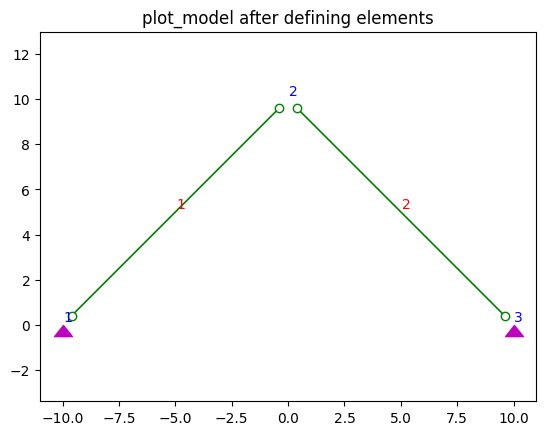

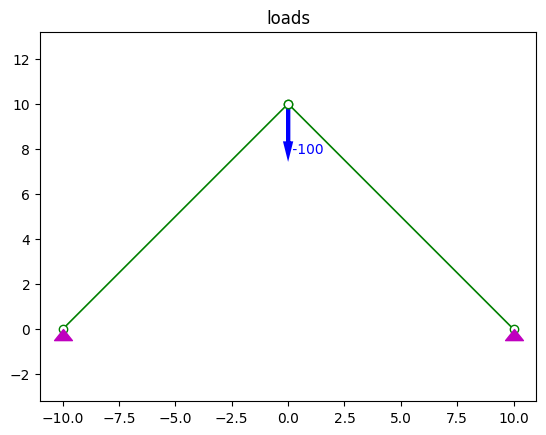

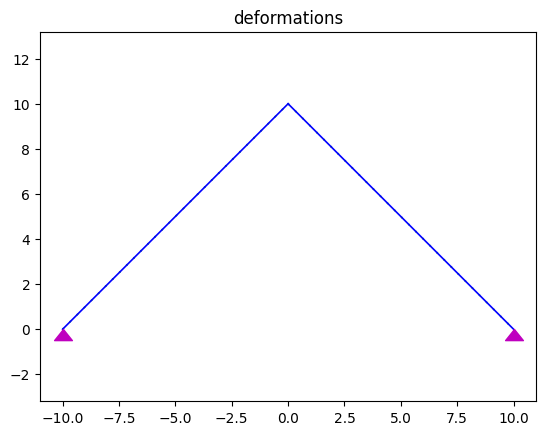

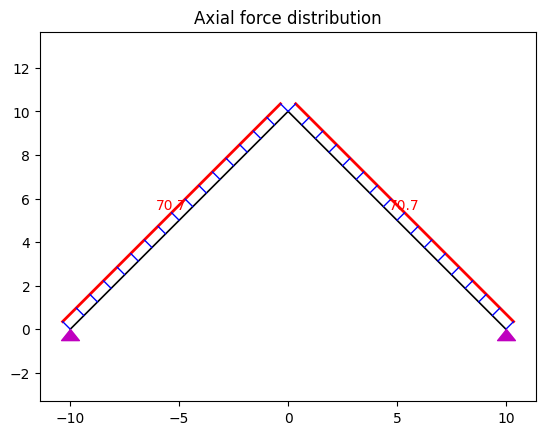

In [50]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 2)

ops.node(1, -L, 0)
ops.node(2, 0, L)
ops.node(3, L, 0)

ops.fix(1, 1, 1)
ops.fix(3, 1, 1)

# define materials
ops.uniaxialMaterial("Elastic", 1, E)

# ops.geomTransf('Linear', 1)

# elements
ops.element('Truss', 1, 1, 2, A, 1)
ops.element('Truss', 2, 2, 3, A, 1)


# loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

ops.load(2, 0, -F)

# analysis
ops.constraints('Plain')
ops.numberer('RCM')
ops.system('BandSPD')
# ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.integrator('LoadControl', 1.0)
ops.algorithm('Linear')
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = .01
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 7.e-3, 6.e-3, 4.e-3
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

plt.show()


In [51]:
for i in range(1,4):
    print(ops.nodeDisp(i))

[0.0, 0.0]
[0.0, -0.07071067811865477]
[0.0, 0.0]
